In [1]:
from obspy.core import Stream, read
import numpy as np
from pytensor.compile.ops import as_op
import pytensor
import pytensor.tensor as pt
import matplotlib.pyplot as plt
import pandas as pd
import os 
import os.path
import pymc as pm
import arviz as az

In [2]:
# What exactly are the colunns here? Amplitude of waves at a specific time?
# My equivalent = peak strain at a specific time

# Build the target function, misfit to this is what is being minimized
@as_op(itypes=[pt.dvector,pt.dscalar,pt.dscalar,pt.dscalar,pt.dscalar,pt.dscalar], otypes=[pt.dvector]) # input variable types and output variable type(s)
def two_straight_lines(x,m1,m2,xinter,x0,y0):
    '''
    input x coordiantes are in x
    slopes are m1 and m2
    intercept of left hand line is b1 
    intersection of two lines is at xinter
    
    Note that y intercept of second straight line is dependent on b1 and xinter
      and defined entirely by them (so that the lines touch).
    '''
    
    # Output vector
    y_out = np.ones(len(x))
    
    # Before building the first straight line, calculate the intercept
    b1 = y0 - m1*x0
    
    # Build first straight line segment
    y_out = m1*x + b1
    
    # Find points that are after the intersection and make the second segment
    i = np.where(x>xinter)[0]
    
    # Define second y intercept
    b2 = m1*xinter + b1 - m2*xinter
    # print(b2)
    
    # Make second straight line
    y_out[i] = m2*x[i] + b2

    return y_out

# Build the target function, misfit to this is what is being minimized
def non_pytensor_two_straight_lines(x,m1,m2,xinter,x0,y0):
    '''
    input x coordiantes are in x
    slopes are m1 and m2
    intercept of left hand line is b1 
    intersection of two lines is at xinter
    
    Note that y intercept of second straight line is dependent on b1 and xinter
      and defined entirely by them (so that the lines touch).
    '''
    
    # Output vector
    yout = np.ones(len(x))
    
    # Before building the first straight line, calculate the intercept
    b1 = y0 - m1*x0
    
    # Build first straight line segment
    yout = m1*x + b1
    
    # Find points that are after the intersection and make the second segment
    i = np.where(x>xinter)[0]
    
    # Define second y intercept
    b2 = m1*xinter + b1 - m2*xinter
    
    # Make second straight line
    yout[i] = m2*x[i] + b2

    return yout

In [3]:
path = '/Users/sydneydybing/StrainProject/2024/taiwan_strain_data/'
events = pd.read_csv(path + 'events_csv.csv')
snr_array = pd.read_csv(path + 'station_data_hypdists_snrs.csv')
snr_array

,Sta,Lat,Lon,Depth(m),2009_hyp_dist_km,2013_hyp_dist_km,2018_hyp_dist_km,snrs_2009,snrs_2013,snrs_2018
0,BCWB,24.2184,121.6891,-192,69.496535,74.182696,7.066640,-,-,-
1,TRKB,24.1614,121.6127,-192,61.088805,65.767547,9.697232,-,1152.20250487,3719.0718215
2,NTTB,24.1728,121.5259,-175,60.587926,65.180780,18.587874,270.716195265,-,-
3,SJNB,24.1073,121.6006,-193,54.988063,59.668808,12.226300,-,1534.07924347,130.500478359
4,HGSB,23.4903,121.4237,-266,15.739505,11.125139,79.319331,643.763657629,439.289654937,372.018353576
5,CHMB,23.4868,121.4703,-191,15.969342,11.924641,78.079695,-,348.253341927,40.3376474275
6,SSNB,23.4423,121.3981,-185,21.504342,16.833483,85.224271,-,766.890947625,129.005945014
7,ZANB,23.3947,121.4585,-218,26.068219,21.740867,88.175343,518.693832246,3295.27964074,106.461336916
8,FBRB,23.1406,121.2796,-200,56.994188,52.307853,120.756809,63.9760386988,410.300738921,80.3548941939
9,SSTB,23.1340,121.3782,-199,55.447392,50.858196,118.191393,-,359.179515365,47.0870229521


In [4]:
events

,evt_id,origin_time,lat,lon,depth
0,2009-10-03_M6.1,2009-10-03T17:36:06.120,23.630,121.452,28.0
1,2013-10-31_M6.3,2013-10-31T12:02:08.720,23.590,121.437,10.0
2,2018-02-04_M6.1,2018-02-04T13:56:41.950,24.157,121.708,12.0


In [ ]:
events_list = []
mags_list = []
stas_list = []
hypdist_list = []
xhighs_list = []
m1s_list = []
m2s_list = []
xinters_list = []
sigmas_list = []
trans_time_list = []

for ii in range(len(events)):
    
    evt_id = events['evt_id'][ii]
    print(evt_id)

    for idx in range(len(snr_array)):

        sta = snr_array['Sta'][idx]
        
        # Figure out the bounds for the MCMC based on the event and hypocentral distance (rainbow plots)
        xlow = 10
        
        if evt_id == '2009-10-03_M6.1':
            mag = '6.1'
            hypdist = snr_array['2009_hyp_dist_km'][idx]
            if sta == 'ZANB':
                xhigh = 17
            elif sta == 'NTTB' or sta == 'HGSB':
                xhigh = 22
            elif sta == 'FBRB':
                xhigh = 29
        elif evt_id == '2013-10-31_M6.3':
            mag = '6.3'
            hypdist = snr_array['2013_hyp_dist_km'][idx]
            if sta == 'FBRB' or sta == 'SSTB' or sta == 'DONB':
                xhigh = 30
            elif sta == 'HGSB' or sta == 'CHMB' or sta == 'ZANB':
                xhigh = 20
            elif sta == 'TRKB' or sta == 'SJNB':
                xhigh = 25
            elif sta == 'SSNB':
                xhigh = 15
            else:
                print('2013 sta typo ' + str(sta))
        elif evt_id == '2018-02-04_M6.1':
            mag = '6.1'
            hypdist = snr_array['2018_hyp_dist_km'][idx]
            if sta == 'TRKB' or sta == 'SJNB':
                xhigh = 13
            elif sta == 'HGSB' or sta == 'CHMB' or sta == 'SSNB' or sta == 'ZANB':
                xhigh = 35
            elif sta == 'FBRB' or sta == 'SSTB':
                xhigh = 55
            else:
                print('2018 sta typo ' + str (sta))
        
        int_hypdist = int(hypdist)
        
        # if evt_id == '2013-10-31_M6.3' and sta == 'SSNB' or sta == 'SSTB':
        #     pass
        # elif evt_id == '2018-02-04_M6.1' and sta == 'TRKB':
        #     pass
        # else:
        #     continue
        
        try:
            pst = read(path + 'filtered_abs_peak_post_p/' + evt_id + '/' + sta + '.mseed')
        except:
            print('Skipping ' + sta + ', no data')
            continue

        print('Processing ' + str(sta))
        
        times = pst[0].times()
        data = pst[0].data
        log10_data = np.log10(data)
        samp_rate = pst[0].stats.sampling_rate
        print(samp_rate)
        
        vec_start = int(xlow*samp_rate)
        vec_end = int(xhigh*samp_rate)

        # Split into x and y vectors
        xobserved = times[vec_start:vec_end]
        yobserved = log10_data[vec_start:vec_end]
        x0 = xobserved[0]
        y0 = yobserved[0]
        
        # in order to pass the x variable into the target function it needs to be 
        # converted to a Theano "shared" variable
        pt_xobserved = pytensor.shared(xobserved)
        pt_x0 = pytensor.shared(x0)
        pt_y0 = pytensor.shared(y0)
            
        # MCMC run parameters, these are good numbers for a "production" run. If you are
        # fooling arund these can be lower to iterate faster
        Nburn = 5000 # burn in samples that get discarded
        Nmcmc = 15000 # bump to at least 5-10k
        Nchains = 4
        Ncores = 1
        
        # Bounds for the prior distributions
        m1_low = -1; m1_high = 20
        m2_low = -1; m2_high = 3
        xinter_low = 10 ; xinter_high = 25 # location of the line slope change
        
        # Define the Bayesian model
        with pm.Model()as model:
            
            # Use normal distributions as priors
            m1 = pm.Uniform('m1', lower = m1_low, upper = m1_high)
            m2 = pm.Uniform('m2', lower = m2_low, upper = m2_high)
            # m1 = pm.Normal('m1', mu = 0.5, sigma = 1)
            # m2 = pm.Normal('m2', mu = -0.1, sigma = 5)
            xinter = pm.Uniform('xinter', lower = xinter_low, upper = xinter_high)
            sigma = pm.HalfCauchy('sigma', beta = 10, initval = 1)
        
            # This is the model
            likelihood = pm.Normal('y', mu = two_straight_lines(pt_xobserved,m1,m2,xinter,pt_x0,pt_y0),
                                    observed = yobserved, sigma = sigma)

            # NUTS sampler (default) is gradient based and won't work, use metropolis
            step = pm.Metropolis(scaling = 0.1)
            
            # This runs the mcmc sampler
            mcmc = pm.sample(Nmcmc, tune = Nburn, chains = Nchains, cores = Ncores, step = step)
        
        # Done, now is post-processing to get the data out of the sampler

        posterior = az.extract(mcmc)
        
        # Unwrap coeficients - WRITE LINES TO SAVE THE ARRAYS!!!
        m1_array = posterior.m1.values
        m1 = np.mean(m1_array)
        # print('m1 mean: ' + str(round(m1,2)))
        
        m2_array = posterior.m2.values
        m2 = np.mean(m2_array)
        # print('m2 mean: ' + str(round(m2,2)))
        
        xinter_array = posterior.xinter.values
        xinter = np.mean(xinter_array)
        # print('xinter Mean: ' + str(round(xinter,2)))
        
        sigma_array = posterior.sigma.values
        sigma = np.mean(sigma_array)

        # Lines!
        b1 = y0 - m1*x0
        b2 = m1*xinter + b1 - m2*xinter
        
        # Make plot to check stuff
        xpredicted = np.arange(xobserved.min(), xobserved.max()+0.1, 0.1)
        ypredicted = m1*xpredicted + b1
        i = np.where(xpredicted > xinter)[0]
        ypredicted[i] = m2*xpredicted[i] + b2
        
        # Get one-sigma region (need to obtain a ton of forward models and get stats)
        N = len(posterior.m1.values)
        
        yfit = np.zeros((len(xpredicted), N))
        for k in range(N):
            yfit[:,k] = non_pytensor_two_straight_lines(xpredicted,m1_array[k],m2_array[k],xinter_array[k],x0,y0)
        mu = yfit.mean(1)
        sig = yfit.std(1) * 1.95 #for 95% confidence
        mu_plus = mu + sig
        mu_minus = mu - sig
        
        # Least squares
        mls, bls = np.polyfit(xobserved, yobserved, 1)
        
        # Find the transition point in ypredicted
        diff = np.round(np.diff(ypredicted), decimals = 5)
        # print(diff)
        first_slope = diff[0]
        second_slope = diff[-1]
        trans_idx = np.where((diff != first_slope) & (diff != second_slope))[0][0] + 1
        
        # Get the transition point
        mcmc_trans_x = xpredicted[trans_idx] # Number
        mcmc_trans_y = ypredicted[trans_idx]
        
        # Append things
        events_list.append(evt_id)
        mags_list.append(mag)
        stas_list.append(sta)
        hypdist_list.append(int_hypdist)
        xhighs_list.append(xhigh)
        m1s_list.append(m1)
        m2s_list.append(m2)
        xinters_list.append(xinter)
        sigmas_list.append(sigma)
        trans_time_list.append(mcmc_trans_x)
        
        # Create folder for the event
        array_save_dir = path + 'mcmc_arrays/' + evt_id + '/' + sta + '/'
        if os.path.isdir(array_save_dir):
            pass
        else:
            os.makedirs(array_save_dir)

        np.save(array_save_dir + 'xobserved.npy', xobserved)
        np.save(array_save_dir + 'yobserved.npy', yobserved)
        np.save(array_save_dir + 'xpredicted.npy', xpredicted)
        np.save(array_save_dir + 'ypredicted.npy', ypredicted)
        np.save(array_save_dir + 'forward_mus.npy', mu)
        np.save(array_save_dir + 'foward_sigs.npy', sig)
        
        summary = az.summary(mcmc, fmt = 'wide')
        print(summary)
        summary.to_csv(array_save_dir + 'mcmc_summary.csv', index = False)
        
        # Folder for figures
        fig_save_dir = path + 'mcmc_plots/' + evt_id + '/'
        if os.path.isdir(fig_save_dir):
            pass
        else:
            os.makedirs(fig_save_dir)
        
        az.plot_trace(mcmc)
        # plt.show()
        plt.savefig(fig_save_dir + sta + '_stats_plots.png', format = 'PNG')
        plt.close()

        # Plot all solutions
        fig = plt.figure(dpi = 100)
        ax = fig.add_subplot(111)
        ax.set_title(str(sta))
        
        ax.plot(xobserved, yobserved, color = 'blue', label = 'Observed (log peak strain)')
        ax.plot(xpredicted, ypredicted, color = 'red', label = 'Predicted (MCMC)')
        # ax.plot(xpredicted, mu, color = 'green', linestyle = '--', label = 'yfit')
        # ax.plot(xpredicted, xpredicted * mls + bls, color = 'orange', label = 'np.polyfit least squares')
        ax.scatter(xpredicted[trans_idx], ypredicted[trans_idx], marker = 'o', color = 'black', label = 'Transition at ' + str(round(xpredicted[trans_idx],2)) + ' sec')
        # ax.scatter(closest_trans_x, closest_trans_y, marker = 'o', color = 'green', label = 'Adjusted transition at ' + str(round(closest_trans_x,2)) + ' sec')
        # ax2 = ax.twinx()
        # ax2.plot(xobserved, pythags_arr, color = 'violet')
        # ax2.axhline(closest_trans_x, color = 'violet', linestyle = '--')
        ax.fill_between(xpredicted, mu_plus, mu_minus, color = 'gray', alpha = 0.2, label = '95% confidence') # 95% confidence interval
        ax.set_xlabel('Time (s) - p-wave at 10s')
        ax.set_ylabel('log10 of peak strain')
        # ax.set_xlim(10,13)
        ax.legend()
        
        # plt.show()
            
        plt.savefig(fig_save_dir + sta + '.png', format = 'PNG')
        plt.close()

2009-10-03_M6.1
Skipping BCWB, no data
Skipping TRKB, no data
Processing NTTB
100.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


In [ ]:
mcmc_array = np.column_stack((np.array(events_list), np.array(mags_list), np.array(stas_list), np.array(hypdist_list),
                             np.array(xhighs_list), np.array(m1s_list), np.array(m2s_list), np.array(xinters_list),
                             np.array(sigmas_list), np.round(np.array(trans_time_list),2)))

mcmc_array

In [ ]:
# # Insert the re-run stations into the results array

# old_mcmc_array = np.load(path + 'mcmc_arrays/mcmc_colstack_array.npy')
# print(old_mcmc_array.shape)

# ssnb13 = np.where((old_mcmc_array[:,0] == '2013-10-31_M6.3') & (old_mcmc_array[:,2] == 'SSNB'))[0]
# # print(old_mcmc_array[ssnb13])
# sstb13 = np.where((old_mcmc_array[:,0] == '2013-10-31_M6.3') & (old_mcmc_array[:,2] == 'SSTB'))[0]
# # print(old_mcmc_array[sstb13])
# trkb18 = np.where((old_mcmc_array[:,0] == '2018-02-04_M6.1') & (old_mcmc_array[:,2] == 'TRKB'))[0]
# # print(old_mcmc_array[trkb18])

# del_array = np.delete(old_mcmc_array, [ssnb13, sstb13, trkb18], axis = 0)
# print(del_array.shape)

# ins_array = np.insert(del_array, ssnb13, mcmc_array[0], axis = 0)
# ins_array = np.insert(ins_array, sstb13, mcmc_array[1], axis = 0)
# ins_array = np.insert(ins_array, trkb18, mcmc_array[2], axis = 0)
# print(ins_array.shape)

# # pd_old = pd.DataFrame(old_mcmc_array)
# # pd_ins = pd.DataFrame(ins_array)

# np.save(path + 'mcmc_arrays/mcmc_colstack_array.npy', ins_array)

In [ ]:
mcmc_array = np.column_stack((np.array(events_list), np.array(mags_list), np.array(stas_list), np.array(hypdist_list),
                             np.array(xhighs_list), np.array(m1s_list), np.array(m2s_list), np.array(xinters_list),
                             np.array(sigmas_list), np.round(np.array(trans_time_list),2)))

np.save(path + 'mcmc_arrays/mcmc_colstack_array.npy', mcmc_array)

In [ ]:
taiwan_mcmc_array = np.load(path + 'mcmc_arrays/mcmc_colstack_array.npy')
taiwan_mcmc_array.shape

# Columns:
# 0. Event name
# 1. Magnitude
# 2. Station name
# 3. Hypocentral distance (km)
# 4. xhigh
# 5. m1 slope
# 6. m2 slope
# 7. intersection point
# 8. sigma
# 9. transition time

In [ ]:
na_mcmc_array = np.load('/Users/sydneydybing/StrainProject/2024/filtered_mcmc_arrays/summary_array.npy')
na_mcmc_array.shape

In [ ]:
tohoku = pd.read_csv('/Users/sydneydybing/StrainProject/2024/tohoku_strain_data/stations_hypdists_snrs_flatsecs.list')
# tohoku
tohoku_mcmc_array = np.load('/Users/sydneydybing/StrainProject/2024/tohoku_strain_data/mcmc_arrays/mcmc_colstack_array.npy')
tohoku_mcmc_array.shape

In [ ]:
# Calculate earthquake source durations

# Get M0 from Mw, then use relation in Melgar and Hayes, 2017 to get duration

mags_for_relation = np.arange(6,9.25,0.25)
# print(mags_for_dur)

# Preferred params for source duration
apref_sd = -6.407
bpref_sd = 0.385

apref_rt = -5.323
bpref_rt = 0.293

source_durs = []
rise_times = []

for Mw in mags_for_relation:
    
    M0 = 10**(1.5*Mw + 9.05)
    # print(M0)
    
    log_sd = apref_sd + bpref_sd * np.log10(M0)
    source_dur = 10**log_sd
    source_durs.append(source_dur)
    
    log_rt = apref_rt + bpref_rt * np.log10(M0)
    rise_time = 10**log_rt
    rise_times.append(rise_time)
    

In [ ]:
plt.scatter(na_mcmc_array[:,1].astype(float), np.log10(na_mcmc_array[:,9].astype(float)-10), label = 'North America')
plt.scatter(taiwan_mcmc_array[:,1].astype(float), np.log10(taiwan_mcmc_array[:,9].astype(float)-10), label = 'Taiwan (dilatometers)')
plt.scatter(tohoku_mcmc_array[:,1].astype(float), np.log10(tohoku_mcmc_array[:,9].astype(float)-10), label = 'Tohoku')
plt.plot(mags_for_relation, np.log10(source_durs), color = 'lime', label = 'Source duration scaling')
plt.plot(mags_for_relation, np.log10(rise_times), color = 'turquoise', label = 'Rise time scaling')
plt.xlabel('Earthquake magnitude')
plt.ylabel('Log10 of transition time (s)')
plt.legend(loc = 'upper left');

In [232]:
# Get mean transition time by event

# North America

na_unique_eventids = np.unique(na_mcmc_array[:,0])

na_mags = []
na_mean_trans_times = []

for uni_id in na_unique_eventids:
    
    print(uni_id)
    i = np.where(uni_id == na_mcmc_array[:,0])[0]
    # print(i)
    
    trans_times = na_mcmc_array[i,9].astype(float)-10
    mag = na_mcmc_array[i,1].astype(float)[0]
    # print(mags)
    print(trans_times)
    
    mean_trans_time = np.mean(trans_times)
    # print(mean_trans_time)
    
    na_mags.append(mag)
    na_mean_trans_times.append(mean_trans_time)
    
na_mags = np.array(na_mags)
na_mean_trans_times = np.array(na_mean_trans_times)

# Taiwan

taiwan_unique_eventids = np.unique(taiwan_mcmc_array[:,0])

taiwan_mags = []
taiwan_mean_trans_times = []

for uni_id in taiwan_unique_eventids:
    
    print(uni_id)
    i = np.where(uni_id == taiwan_mcmc_array[:,0])[0]
    # print(i)
    
    trans_times = taiwan_mcmc_array[i,9].astype(float)-10
    mag = taiwan_mcmc_array[i,1].astype(float)[0]
    # print(mags)
    print(trans_times)
    
    mean_trans_time = np.mean(trans_times)
    # print(mean_trans_time)
    
    taiwan_mags.append(mag)
    taiwan_mean_trans_times.append(mean_trans_time)
    
taiwan_mags = np.array(taiwan_mags)
taiwan_mean_trans_times = np.array(taiwan_mean_trans_times)

# Tohoku

tohoku_mags = 9.1
tohoku_mean_trans_times = np.mean(taiwan_mcmc_array[:,9].astype(float)-10)

2010-01-10_M6.5
[9.  3.6 3.  3.1 6.8 2.5 2.1]
2010-04-04_M7.2
[7.1]
2011-09-09_M6.4
[4.2 1.7 1.7 1.5 1.7 1.2 0.8 0.9 1.1 0.6 2.1 2.6 2.  2.6 0.9 1.3 5.8 1.4
 1.2]
2012-04-11_M6
[1.8 2.9 2.6 3.2 2.7 3.1 3.  2.4 2.  2.1 3.  2.9 0.7 3.1]
2012-11-08_M6.1
[2.4 3.  1.5 1.  2.  2.4 3.7 1.7 1.5 2.6]
2012-12-14_M6.3
[4.2 2.6 5.6 1.  3.4]
2013-09-03_M6.1
[3.6]
2014-03-10_M6.8
[4.  3.5 3.4 3.7 2.4 2.5 3.7 7.8 1.2 1.5 3.6 2.4]
2014-04-24_M6.5
[3.6 4.  3.9 2.9 3.4 2.3 3.3 3.  2.9 3.1 4. ]
2014-08-24_M6.02
[ 0.9  1.6  1.4  2.6  2.3  4.3  5.5 10.9]
2016-12-08_M6.6
[4.  2.8 5.1 4.3 3.4 6.4 3.6 5.5 4.8]
2018-08-22_M6.2
[3.5 2.4 2.7 3.2 3.6 2.6 2.4 3.2 1.8 2.2 4.1 2.7]
2018-10-22T05_M6.5
[8.2 5.6 7.9 5.8 6.3 6.4]
2018-10-22_M6.8
[13.8 14.9]
2019-07-04_M6.2
[4.4 4.1]
2019-07-04_M6.4
[ 0.2  9.6  5.8 10.4  9.3  7.  10.2  8.2  9.4 11.3  8.3  6.   7.6  1.1
  1.1  0.7  1.3]
2019-07-06_M7.1
[ 7.8  7.4  8.7 11.9  6.2  8.9 12.7  3.2 10.  10.3  9.5  9.4  6.5  8.8
  9.7  4.3  7.3  4.3  9.3]
2019-08-29_M6.3
[4.3 3.

In [ ]:
m, b = np.polyfit(mags, np.log10(mean_trans_times), 1)
ma, ba = np.polyfit(mcmc_array[:,1].astype(float), np.log10(mcmc_array[:,9].astype(float)-10), 1)

NameError: name 'mags' is not defined

Text(0, 0.5, 'Log10 of transition time (s)')

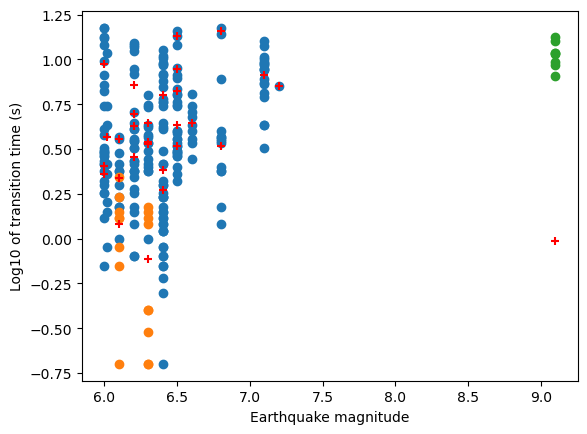

In [233]:
# plt.scatter(mcmc_array[:,3].astype(float), mcmc_array[:,9].astype(float)-10)
# plt.xlabel('Hypocentral distance (km)')
# plt.ylabel('Transition time (s)')
# plt.show()

plt.scatter(na_mcmc_array[:,1].astype(float), np.log10(na_mcmc_array[:,9].astype(float)-10), label = 'North America')
plt.scatter(taiwan_mcmc_array[:,1].astype(float), np.log10(taiwan_mcmc_array[:,9].astype(float)-10), label = 'Taiwan (dilatometers)')
plt.scatter(tohoku_mcmc_array[:,1].astype(float), np.log10(tohoku_mcmc_array[:,9].astype(float)-10), label = 'Tohoku')
plt.scatter(na_mags, np.log10(na_mean_trans_times), marker = '+', color = 'red', label = 'Mean transition time by event')
plt.scatter(taiwan_mags, np.log10(taiwan_mean_trans_times), marker = '+', color = 'red')
plt.scatter(tohoku_mags, np.log10(tohoku_mean_trans_times), marker = '+', color = 'red')
# plt.plot(mags_for_relation, np.log10(source_durs), color = 'lime', label = 'Source duration scaling')
# plt.plot(mags_for_relation, np.log10(rise_times), color = 'turquoise', label = 'Rise time scaling')
plt.xlabel('Earthquake magnitude')
plt.ylabel('Log10 of transition time (s)')
# plt.legend(loc = 'upper left');

# plt.scatter(na_mcmc_array[:,1].astype(float), np.log10(na_mcmc_array[:,9].astype(float)-10))
# plt.scatter(mags, np.log10(mean_trans_times), marker = '+', color = 'red', label = 'Mean transition time by event')
# # plt.plot(mags, mags * m + b, color = 'red', lw = 1)
# plt.plot(mcmc_array[:,1].astype(float), mcmc_array[:,1].astype(float) * ma + ba, color = 'C0', lw = 1)
# plt.plot(mags_for_relation, np.log10(source_durs), color = 'lime', label = 'Source duration scaling')
# plt.plot(mags_for_relation, np.log10(rise_times), color = 'turquoise', label = 'Rise time scaling')
# plt.xlabel('Earthquake magnitude')
# plt.ylabel('Log10 of transition time (s)')
# # plt.semilogy()
# plt.legend()
# plt.show()

# plt.scatter(mcmc_array[:,1].astype(float), mcmc_array[:,5].astype(float))
# plt.xlabel('Earthquake magnitude')
# plt.ylabel('Line 1 slope')
# plt.show()

# plt.scatter(mcmc_array[:,1].astype(float), mcmc_array[:,6].astype(float))
# plt.xlabel('Earthquake magnitude')
# plt.ylabel('Line 2 slope')
# plt.show()

In [234]:
pd_mcmc = pd.DataFrame(taiwan_mcmc_array, columns = ['eq_id', 'mag', 'sta', 'hypdist', 'xhigh', 'm1', 'm2', 'xinter', 'sigma', 'trans_time'])
pd_mcmc.to_csv(path + 'mcmc_arrays/mcmc_results_summary.csv', index = False)

In [235]:
# Figure out the "good" and "bad" performing waveforms using an L2 norm

mcmc_results = pd.read_csv(path + 'mcmc_arrays/mcmc_results_summary.csv')
mcmc_results

,eq_id,mag,sta,hypdist,xhigh,m1,m2,xinter,sigma,trans_time
0,2013-10-31_M6.3,6.3,TRKB,65,25,2.037030,0.068694,11.330833,0.189542,11.4
1,2013-10-31_M6.3,6.3,SJNB,59,25,2.177101,0.084947,11.198908,0.149086,11.2
2,2013-10-31_M6.3,6.3,HGSB,11,20,6.050762,0.083554,10.348307,0.124362,10.4
3,2013-10-31_M6.3,6.3,CHMB,11,20,9.867626,0.078880,10.198883,0.096252,10.2
4,2013-10-31_M6.3,6.3,SSNB,16,15,8.369877,0.228925,10.200698,0.094635,10.3
5,2013-10-31_M6.3,6.3,ZANB,21,20,16.232098,0.064102,10.177930,0.105905,10.2
6,2013-10-31_M6.3,6.3,FBRB,52,30,1.609654,0.076036,11.237796,0.117444,11.3
7,2013-10-31_M6.3,6.3,SSTB,50,30,7.683661,0.074869,10.334603,0.125446,10.4
8,2013-10-31_M6.3,6.3,DONB,67,30,1.034044,0.076751,11.411517,0.161596,11.5
9,2018-02-04_M6.1,6.1,TRKB,9,13,10.160986,0.624036,10.175736,0.173316,10.2


In [236]:
print(np.mean(mcmc_results['m1'].values))
print(np.mean(mcmc_results['m2'].values))
print(np.mean(mcmc_results['xinter'].values))

print(np.median(mcmc_results['m1'].values))
print(np.median(mcmc_results['m2'].values))
print(np.median(mcmc_results['xinter'].values))

4.469501487574807
0.12352390802567434
10.9276124080951
2.0370297273159603
0.0748689818519869
11.198908289707564
